In [1]:
from pathlib import Path

parent_dir = str(Path.cwd().parent)
%cd $parent_dir

D:\OrenRichter\Research\pyERGM


D:\OrenRichter\Research\pyERGM\venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f
from metrics import *
from utils import *
from ergm import ERGM

In [3]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1],
     [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
     [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0],
     [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
     [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
     [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0],
     [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
     [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
     [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1],
     [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)


In [116]:
n = sampson_matrix.shape[0]
is_directed = True

estimated_p_seed = np.sum(sampson_matrix) / (n * (n - 1))

metrics = [NumberOfEdgesDirected(), OutDegree(), InDegree()]
# metrics = [NumberOfEdgesDirected()]

model = ERGM(n, metrics, is_directed=is_directed)
model.fit(sampson_matrix)
observed_features = model._network_statistics.calculate_statistics(sampson_matrix)

Removing the 0 feature of outdegree to fix multi-collinearity
Removing the 0 feature of indegree to fix multi-collinearity
Model is dyadic independent - using only MPLE instead of MCMLE


In [117]:
sample_sizes = 1000 * np.array([1, 3, 10, 30, 100, 300], dtype=int)
num_reps_per_size = 1

In [118]:
hotelling_statistics_exact_samples = np.zeros((num_reps_per_size, sample_sizes.size))
for i in range(sample_sizes.size):
    for j in range(num_reps_per_size):
        cur_sample = model.generate_networks_for_sample(sampling_method='exact',
                                                        sample_size=sample_sizes[i])
        print(f"sampled {sample_sizes[i]} networks")
        cur_sample_features = model._network_statistics.calculate_sample_statistics(cur_sample)
        print(f"calculated statistics for sample")
        hotelling_statistics_exact_samples[j, i] = calc_hotelling_statistic_for_sample(
            observed_features,
            cur_sample_features,
            'multivariate_initial_sequence')
        print(f"calculated hotelling for sample")
    print(f"completed repetitions for size {sample_sizes[i]}")

sampled 1000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 1000
sampled 3000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 3000
sampled 10000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 10000
sampled 30000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 30000
sampled 100000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 100000
sampled 300000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 300000


In [113]:
hotelling_statistics_mcmc_samples = np.zeros((num_reps_per_size, sample_sizes.size))
for i in range(sample_sizes.size):
    for j in range(num_reps_per_size):
        cur_sample = model.generate_networks_for_sample(sampling_method='metropolis_hastings',
                                                        seed_network=sampson_matrix,
                                                        burn_in=1000,
                                                        # Probably not really needed, as we can sample exactly from the distribution, but here to imitate exactly what goes on in ERGM.fit() 
                                                        mcmc_steps_per_sample=n,
                                                        sample_size=sample_sizes[i])
        print(f"sampled {sample_sizes[i]} networks")
        cur_sample_features = model._network_statistics.calculate_sample_statistics(cur_sample)
        print(f"calculated statistics for sample")
        hotelling_statistics_mcmc_samples[j, i] = calc_hotelling_statistic_for_sample(
            observed_features,
            cur_sample_features,
            'multivariate_initial_sequence')
        print(f"calculated hotelling for sample")
    print(f"completed repetitions for size {sample_sizes[i]}")

sampled 1000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 1000
sampled 3000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 3000
sampled 10000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 10000
sampled 30000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 30000
sampled 100000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 100000
sampled 300000 networks
calculated statistics for sample
calculated hotteling for sample
completed repetitions for size 300000


In [114]:
confidence_for_convergence = 0.6
hotelling_critical_values = np.zeros(sample_sizes.size)
num_features = model._network_statistics.num_of_features
for i in range(sample_sizes.size):
    hotelling_critical_values[i] = f.ppf(1 - confidence_for_convergence, num_features,
                                         sample_sizes[i] - num_features)

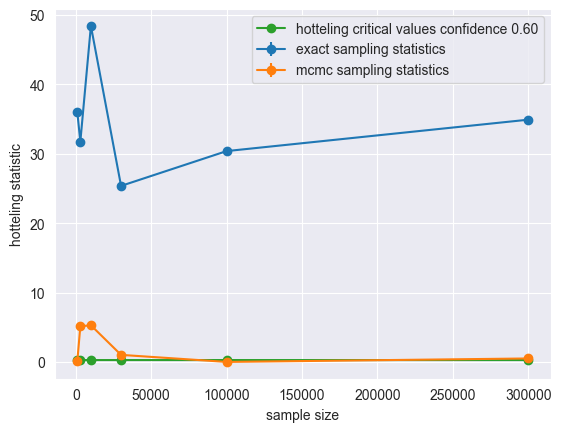

In [119]:
plt.errorbar(sample_sizes, hotelling_statistics_exact_samples.mean(axis=0),
             yerr=hotelling_statistics_exact_samples.std(axis=0), marker='o', label='exact sampling statistics')
plt.errorbar(sample_sizes, hotelling_statistics_mcmc_samples.mean(axis=0),
             yerr=hotelling_statistics_mcmc_samples.std(axis=0), marker='o', label='mcmc sampling statistics')
plt.plot(sample_sizes, hotelling_critical_values, marker='o',
         label=f'hotelling critical values confidence {confidence_for_convergence:.2f}')
plt.xlabel('sample size')
plt.ylabel('hotelling statistic')
plt.legend()
plt.show()

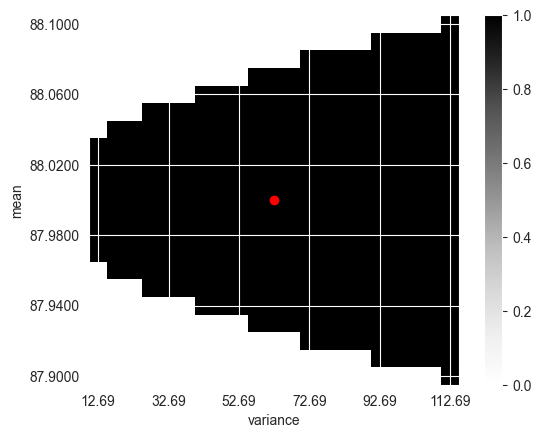

In [94]:
true_num_edges = sampson_matrix.sum()
true_p = true_num_edges / (sampson_matrix.size - n)
true_num_edge_var = (sampson_matrix.size - n) * true_p * (1 - true_p)

sample_size = 3000
hotelling_conf = 0.6
hotelling_critical_value = f.ppf(1 - hotelling_conf, 1, sample_size - 1)

mean_res = 0.01
mean_margin = 0.1
var_res = 5
var_margin = 50
min_considered_num_edges = true_num_edges - mean_margin
max_considered_num_edges = true_num_edges + mean_margin
min_considered_variance = true_num_edge_var - var_margin
max_considered_variance = true_num_edge_var + var_margin
considered_means = np.arange(min_considered_num_edges, max_considered_num_edges + mean_res, mean_res)
considered_variances = np.arange(min_considered_variance, max_considered_variance + var_res, var_res)

mean_var_plane = np.zeros((considered_means.size, considered_variances.size))
for i in range(considered_means.size):
    cur_virtual_sample_mean = considered_means[i]
    first_j_to_cross_thr = np.inf
    for j in range(considered_variances.size):
        cur_virtual_sample_var = considered_variances[j]
        mahalanobis_dist_squared = (cur_virtual_sample_mean - true_num_edges) ** 2 / cur_virtual_sample_var
        cur_virtual_t_stat = sample_size * mahalanobis_dist_squared
        cur_hotelling_t_as_f = ((sample_size - 1) / (1 * (sample_size - 1))) * cur_virtual_t_stat

        if cur_hotelling_t_as_f < hotelling_critical_value:
            mean_idx_in_image = round((considered_means[i] - min_considered_num_edges) / mean_res)
            var_idx_in_image = round((considered_variances[j] - min_considered_variance) / var_res)
            mean_var_plane[mean_idx_in_image, var_idx_in_image] = 1
            first_j_to_cross_thr = j
        else:
            if j > first_j_to_cross_thr:
                print(f'broke at i={i}, j={j}')
                
fig = plt.figure()
ax = fig.add_subplot()
im = ax.imshow(mean_var_plane, origin='lower', cmap='Grays')
colorbar = fig.colorbar(im)
true_mean_idx_in_image = round((true_num_edges - min_considered_num_edges) / mean_res)
true_var_idx_in_image = round((true_num_edge_var - min_considered_variance) / var_res)
plt.plot(true_var_idx_in_image, true_mean_idx_in_image, "or")
plt.yticks([i for i in range(considered_means.size) if i % 4 == 0],
           labels=[f'{considered_means[i]:.4f}' for i in range(considered_means.size) if i % 4 == 0])
plt.xticks([i for i in range(considered_variances.size) if i % 4 == 0],
           labels=[f'{considered_variances[i]:.2f}' for i in range(considered_variances.size) if i % 4 == 0])
plt.xlabel('variance')
plt.ylabel('mean')
plt.show()

In [109]:
(np.sqrt(true_num_edge_var) / 0.02) ** 2

156732.02614379086